In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.offline as pyo
# import plotly.graph_objects as go
# import plotly.io as pio
# import plotly.express as px
import time
import os
import seaborn as sns
import sklearn

In [86]:
df = pd.read_csv("./data/definitivo.csv")
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1113 entries, 0 to 1112
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   municipio           1113 non-null   int64  
 1   tipo_vivienda       1113 non-null   int64  
 2   habitaciones        1113 non-null   float64
 3   metros_cuadrados    1113 non-null   float64
 4   aseos               1113 non-null   float64
 5   planta              1113 non-null   float64
 6   garaje              1113 non-null   int64  
 7   zona_centro         1113 non-null   int64  
 8   ascensor            1113 non-null   int64  
 9   piscina             1113 non-null   int64  
 10  reformado           1113 non-null   int64  
 11  terraza             1113 non-null   int64  
 12  aire_acondicionado  1113 non-null   int64  
 13  precio              1113 non-null   float64
dtypes: float64(5), int64(9)
memory usage: 121.9 KB


## En este notebook se realizará la predicción del precio de la vivienda con el modelo **GradientBoostingRegressor**:

### El GradientBoostingRegressor es un **modelo de boosting que combina múltiples modelos débiles** (normalmente árboles de decisión) **para crear un modelo fuerte**. Cada árbol intenta corregir los errores de predicción del árbol anterior, optimizando una función de pérdida (como el error cuadrático medio).

### - **Modelo inicial**: Empieza con una predicción inicial (como la media de y_train).
### - **Residuos**: Calcula los residuos (errores) entre las predicciones y los valores reales.
### - **Árbol adicional**: Entrena un árbol que predice los residuos.
### - **Actualización**: Actualiza las predicciones sumando las nuevas predicciones del árbol con un peso ajustado por el learning rate.
### - **Iteración**: Repite este proceso durante un número de iteraciones o hasta que no haya mejora.

In [87]:
df.describe() # Mostramos datos estadisticos descriptivos y nos fijamos principalmente en la media.

,municipio,tipo_vivienda,habitaciones,metros_cuadrados,aseos,planta,garaje,zona_centro,ascensor,piscina,reformado,terraza,aire_acondicionado,precio
count,1113.00,1113.00,1113.00,1113.00,1113.00,1113.00,1113.00,1113.00,1113.00,1113.00,1113.00,1113.00,1113.00,1113.00
mean,1.76,3.60,3.39,172.39,1.98,2.11,0.20,0.23,0.08,0.02,0.00,0.12,0.01,302495.07
std,1.04,1.78,1.22,137.44,0.78,1.92,0.40,0.42,0.27,0.14,0.03,0.32,0.11,269938.34
min,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11800.00
25%,1.00,2.00,3.00,88.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,139000.00
50%,1.00,5.00,3.00,116.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,220000.00
75%,3.00,5.00,4.00,210.00,2.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,350000.00
max,5.00,6.00,11.00,961.00,11.00,15.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2000000.00


<Axes: >

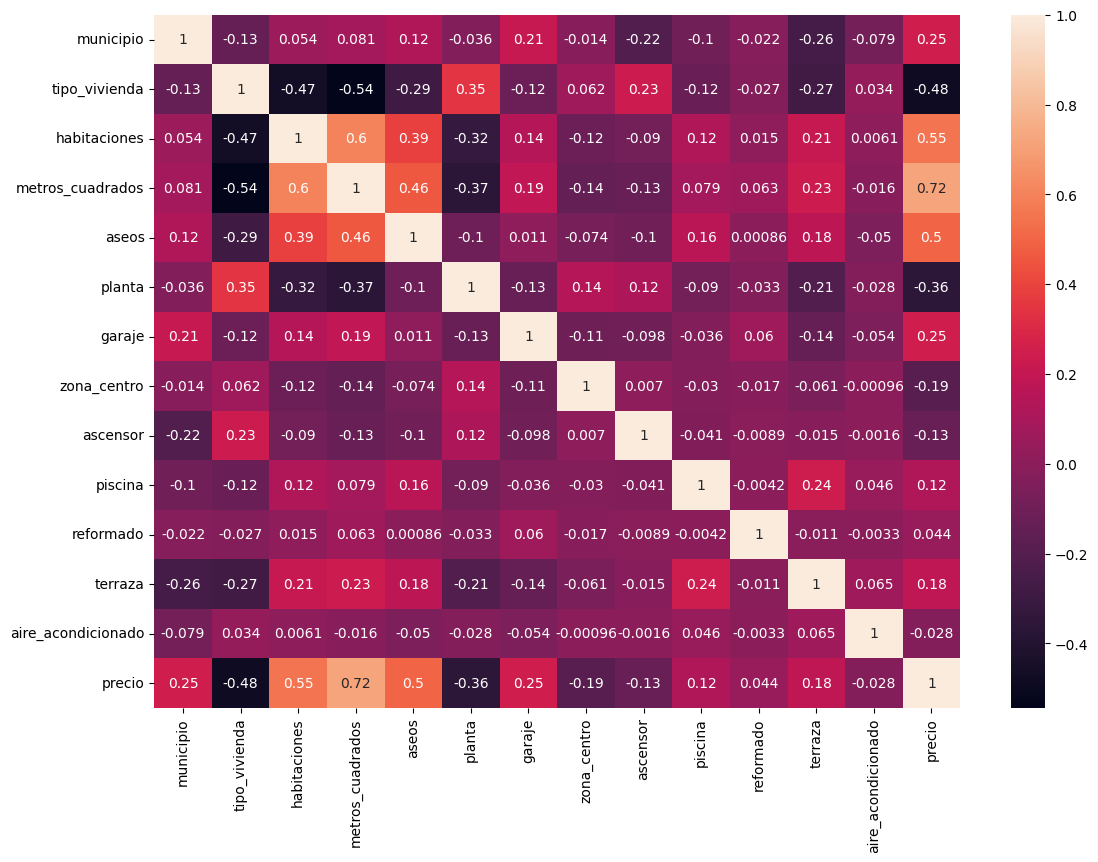

In [4]:
fig = plt.figure(figsize=(13,9))
sns.heatmap(df.corr(), annot=True) # Vemos las correlaciones importantes

<Axes: xlabel='precio', ylabel='Count'>

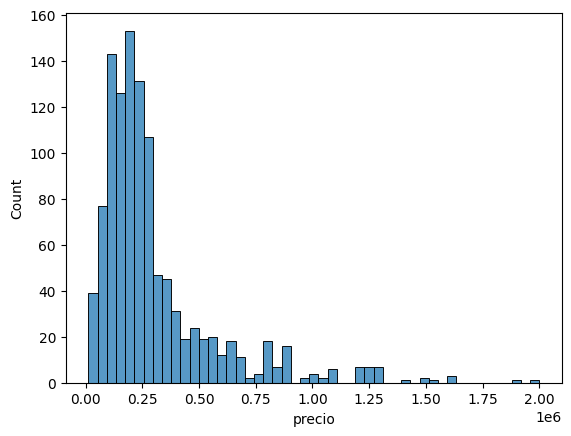

In [5]:
sns.histplot(df["precio"])

## Transformación logarítmica

### En el caso de utilizar arboles, como GradientBoostingRegressior, **NO es necesario transformar**, de hecho se ha podido comprobar que es peor todavía. A los modelos como este no le afectan los outliers.

## Normalización

### **Tampoco requiere normalización**. A diferencia de modelos como Regresión Lineal, GradientBoosting **no es sensible a la escala de las variables**. 


In [88]:
from sklearn.model_selection import train_test_split

# Las columnas de las features (X)

X = df[['municipio', 'tipo_vivienda', 'habitaciones', 'metros_cuadrados',
       'aseos', 'planta', 'garaje', 'zona_centro', 'ascensor', 'piscina',
       'reformado', 'terraza', 'aire_acondicionado']]

# La columna del target (y)
y = df["precio"]

# Dividimos
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20, random_state=42) 

print("Total shape:", X.shape)
print("Train features shape (X):", X_train.shape)
print("Train target shape (y):", y_train.shape)
print("Test features shape (X):", X_test.shape)
print("Test target shape (y):", y_test.shape)
print()

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Configura el modelo
gbr = GradientBoostingRegressor(
    n_estimators=100,       # Número de árboles
    learning_rate=0.1,      # Tasa de aprendizaje
    max_depth=3,            # Profundidad máxima del árbol
    random_state=42         # Reproducibilidad
)

# Entrena el modelo
gbr.fit(X_train, y_train)

# Predicciones
y_pred = gbr.predict(X_test)

# Métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MAPE:", mape)
print("RMSE:", rmse)
print("R2:", r2)

Total shape: (1113, 13)
Train features shape (X): (890, 13)
Train target shape (y): (890,)
Test features shape (X): (223, 13)
Test target shape (y): (223,)

MAE: 84328.35576741991
MAPE: 0.3771947522936119
RMSE: 130731.105567155
R2: 0.6979865241908769


## Vamos a preparar **código para observar outliers**, *posiblemente eliminarlos* y hacer pruebas para tratar de obtener mejores métricas del modelo sin ellos:

In [89]:
pd.set_option('display.float_format', '{:.2f}'.format) # Para mostrar los numeros completos sin anotacion cientifica

df["precio"].describe()

count      1113.00
mean     302495.07
std      269938.34
min       11800.00
25%      139000.00
50%      220000.00
75%      350000.00
max     2000000.00
Name: precio, dtype: float64

#### Detectamos los valores fuera del rango de los quartiles

In [90]:
Q1 = df["precio"].quantile(0.25)  # Primer cuartil (25%)
Q3 = df["precio"].quantile(0.75)  # Tercer cuartil (75%)
IQR = Q3 - Q1  # Rango intercuartílico

# Límites para detectar outliers
lower_bound = max(0, Q1 - 1.5 * IQR)  # Ajustar límite inferior a 0 si es negativo
upper_bound = Q3 + 1.5 * IQR

print(f"Valores fuera de los límites: < {lower_bound} o > {upper_bound}")

# Filtrar outliers
outliers = df[df["precio"] > upper_bound]
print(f"Cantidad de outliers detectados: {len(outliers)}")

Valores fuera de los límites: < 0 o > 666500.0
Cantidad de outliers detectados: 101


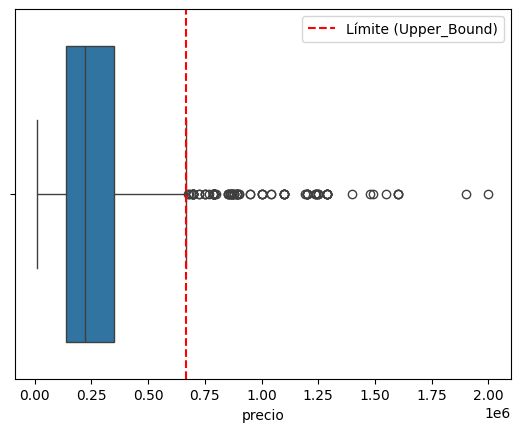

In [9]:
sns.boxplot(x=df["precio"])
plt.axvline(upper_bound, color='r', linestyle='--', label='Límite (Upper_Bound)')
plt.legend()
plt.show()

#### En caso de eliminarlos, ejecutar la siguiente celda para ajustar el limite de los outliers

Límite superior: 666500.0
Límite superior definitivo a filtrar: 999996.605
Cantidad de outliers detectados ajustados: 42


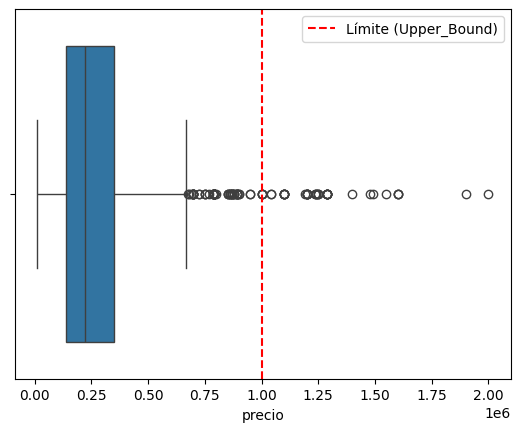

In [95]:
tolerancia = 0.50037  # Incrementa el límite superior del upper_bound (ajusta según tu criterio)
upper_bound_ajustado = upper_bound + (tolerancia * upper_bound)
print(f"Límite superior: {upper_bound}")
print(f"Límite superior definitivo a filtrar: {upper_bound_ajustado}")

# Filtrar outliers
outliers = df[df["precio"] > upper_bound_ajustado]
print(f"Cantidad de outliers detectados ajustados: {len(outliers)}")

# Visualizar
sns.boxplot(x=df["precio"])
plt.axvline(upper_bound_ajustado, color='r', linestyle='--', label='Límite (Upper_Bound)')
plt.legend()
plt.show()

In [96]:
# Filtrar los datos en el df con el límite ajustado
print(f"Cantidad de datos antes de eliminar outliers: {len(df)}")
df = df[df["precio"] <= upper_bound_ajustado]
print(f"Cantidad de datos después de eliminar outliers: {len(df)}")

Cantidad de datos antes de eliminar outliers: 1113
Cantidad de datos después de eliminar outliers: 1071


In [97]:
df["precio"].value_counts().sort_index(ascending=False)

precio
950000.00    2
900000.00    2
890000.00    6
880000.00    3
870000.00    5
            ..
29000.00     1
27335.00     1
27000.00     2
18000.00     1
11800.00     1
Name: count, Length: 308, dtype: int64

### **Probamos de nuevo sin los outliers**, si no mejora volvemos al estado anterior en el dataframe, si mejora continuamos!

### TESTER 1 (Sólo modelo)

In [98]:
from sklearn.model_selection import train_test_split

# Las columnas de las features (X)

X = df[['municipio', 'tipo_vivienda', 'habitaciones', 'metros_cuadrados',
       'aseos', 'planta', 'garaje', 'zona_centro', 'ascensor', 'piscina',
       'reformado', 'terraza', 'aire_acondicionado']]

# La columna del target (y)
y = df["precio"]

# Dividimos
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20, random_state=42) 

print("Total shape:", X.shape)
print("Train features shape (X):", X_train.shape)
print("Train target shape (y):", y_train.shape)
print("Test features shape (X):", X_test.shape)
print("Test target shape (y):", y_test.shape)
print()

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Configura el modelo
gbr = GradientBoostingRegressor(
    n_estimators=100,       # Número de árboles
    learning_rate=0.1,      # Tasa de aprendizaje
    max_depth=3,            # Profundidad máxima del árbol
    random_state=42         # Reproducibilidad
)

# Entrena el modelo
gbr.fit(X_train, y_train)

# Predicciones
y_pred = gbr.predict(X_test)

# Métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MAPE:", mape)
print("RMSE:", rmse)
print("R2:", r2)

Total shape: (1071, 13)
Train features shape (X): (856, 13)
Train target shape (y): (856,)
Test features shape (X): (215, 13)
Test target shape (y): (215,)

MAE: 67105.000171987
MAPE: 0.39363537229208473
RMSE: 86117.40055678523
R2: 0.77217714141303


### VISUALIZACIÓN

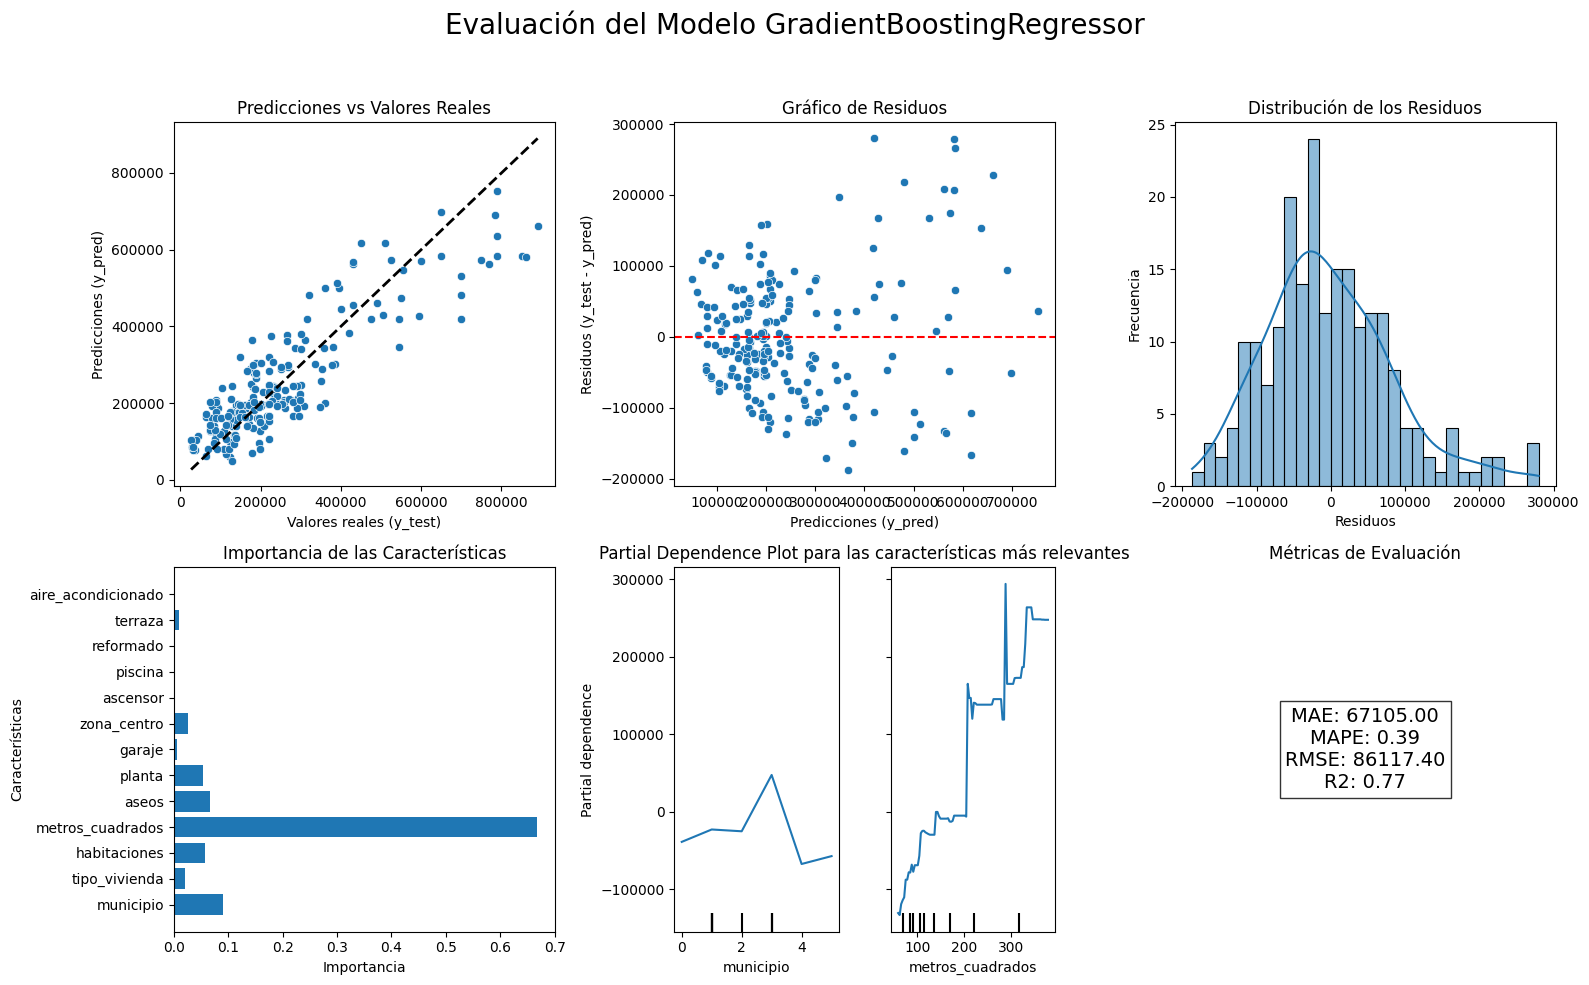

In [23]:
# Calcular residuos
residuos = y_test - y_pred

# Crear la figura y los subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))  # 2 filas, 3 columnas
fig.suptitle("Evaluación del Modelo GradientBoostingRegressor", fontsize=20)

# Gráfico 1: Predicciones vs Valores Reales
sns.scatterplot(x=y_test, y=y_pred, ax=axes[0, 0])
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[0, 0].set_title("Predicciones vs Valores Reales")
axes[0, 0].set_xlabel("Valores reales (y_test)")
axes[0, 0].set_ylabel("Predicciones (y_pred)")

# Gráfico 2: Error de Residuos
sns.scatterplot(x=y_pred, y=residuos, ax=axes[0, 1])
axes[0, 1].axhline(0, color='red', linestyle='--')
axes[0, 1].set_title("Gráfico de Residuos")
axes[0, 1].set_xlabel("Predicciones (y_pred)")
axes[0, 1].set_ylabel("Residuos (y_test - y_pred)")

# Gráfico 3: Distribución de Residuos
sns.histplot(residuos, kde=True, bins=30, ax=axes[0, 2])
axes[0, 2].set_title("Distribución de los Residuos")
axes[0, 2].set_xlabel("Residuos")
axes[0, 2].set_ylabel("Frecuencia")

# Gráfico 4: Importancia de las Características
importances = gbr.feature_importances_
features = X.columns
axes[1, 0].barh(features, importances)
axes[1, 0].set_title("Importancia de las Características")
axes[1, 0].set_xlabel("Importancia")
axes[1, 0].set_ylabel("Características")

# Obtener las dos características más relevantes
importances = gbr.feature_importances_
top_features = [X.columns[i] for i in np.argsort(importances)[-2:]]  # Las 2 más relevantes

# Gráfico 5: Partial Dependence Plot
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(gbr, X_train, top_features, ax=axes[1, 1])
axes[1, 1].set_title("Partial Dependence Plot para las características más relevantes")

# Gráfico 6: Métricas de Evaluación
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
metrics_text = f"MAE: {mae:.2f}\nMAPE: {mape:.2f}\nRMSE: {rmse:.2f}\nR2: {r2:.2f}"
axes[1, 2].text(0.5, 0.5, metrics_text, fontsize=14, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))
axes[1, 2].set_title("Métricas de Evaluación")
axes[1, 2].axis('off')

# Ajustar espaciado
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar para no cortar el título general
plt.show()


## ¡MEJORA!

### Probamos el modelo con **RandomizedSearchCV** para obtener las mejores métricas.

In [37]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Definimos el modelo
gbr = GradientBoostingRegressor(random_state=42)

# Rango de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 300],  # Número de árboles
    'learning_rate': [0.01, 0.05, 0.1, 0.15],  # Tasa de aprendizaje
    'max_depth': [5, 10, 15],  # Profundidad máxima del árbol
    'min_samples_split': [2, 4, 10],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [2, 3, 5],  # Número mínimo de muestras en un nodo hoja
    'subsample': [0.7, 0.8, 1.0]  # Porcentaje de muestras usadas para construir cada árbol
}

# Configuramos RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=50,  # Número de combinaciones a probar
    scoring='neg_mean_squared_error',  # Optimizar el MSE
    cv=5,  # Validación cruzada con 5 pliegues
    random_state=42,
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=1
)

# Entrenamos el modelo con los datos de entrenamiento
random_search.fit(X_train, y_train)

# Obtener el mejor modelo y parámetros
best_gbr = random_search.best_estimator_
print("Mejores parámetros:", random_search.best_params_)

# Predicciones en los datos de prueba
y_pred = best_gbr.predict(X_test)

# Métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MAPE:", mape)
print("RMSE:", rmse)
print("R2:", r2)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.05}
MAE: 60754.55688846879
MAPE: 0.3605568409530402
RMSE: 81512.50165865447
R2: 0.7958901721171097


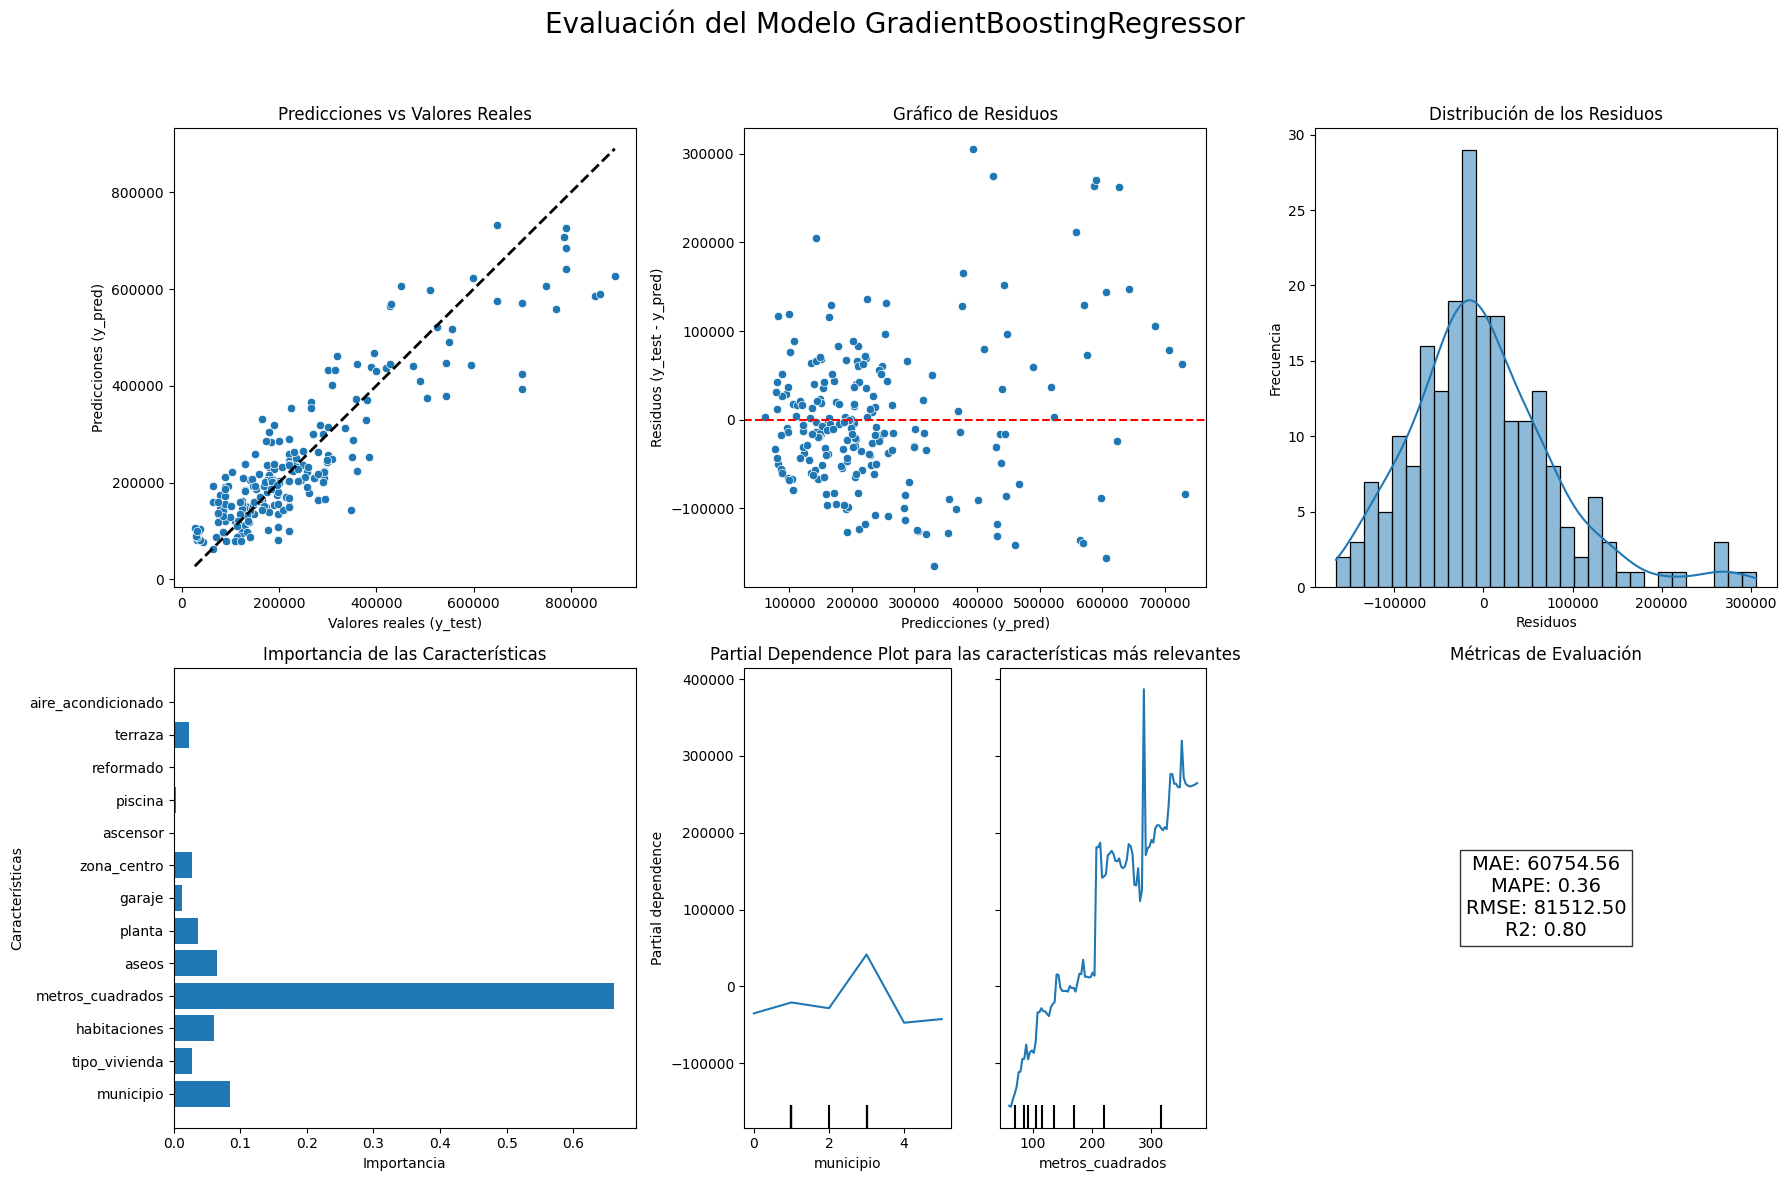

In [39]:
# Calcular residuos
residuos = y_test - y_pred

# Crear la figura y los subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2 filas, 3 columnas
fig.suptitle("Evaluación del Modelo GradientBoostingRegressor", fontsize=20)

# Gráfico 1: Predicciones vs Valores Reales
sns.scatterplot(x=y_test, y=y_pred, ax=axes[0, 0])
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[0, 0].set_title("Predicciones vs Valores Reales")
axes[0, 0].set_xlabel("Valores reales (y_test)")
axes[0, 0].set_ylabel("Predicciones (y_pred)")

# Gráfico 2: Error de Residuos
sns.scatterplot(x=y_pred, y=residuos, ax=axes[0, 1])
axes[0, 1].axhline(0, color='red', linestyle='--')
axes[0, 1].set_title("Gráfico de Residuos")
axes[0, 1].set_xlabel("Predicciones (y_pred)")
axes[0, 1].set_ylabel("Residuos (y_test - y_pred)")

# Gráfico 3: Distribución de Residuos
sns.histplot(residuos, kde=True, bins=30, ax=axes[0, 2])
axes[0, 2].set_title("Distribución de los Residuos")
axes[0, 2].set_xlabel("Residuos")
axes[0, 2].set_ylabel("Frecuencia")

# Gráfico 4: Importancia de las Características
importances = best_gbr.feature_importances_
features = X.columns
axes[1, 0].barh(features, importances)
axes[1, 0].set_title("Importancia de las Características")
axes[1, 0].set_xlabel("Importancia")
axes[1, 0].set_ylabel("Características")

# Obtener las dos características más relevantes
importances = best_gbr.feature_importances_
top_features = [X.columns[i] for i in np.argsort(importances)[-2:]]  # Las 2 más relevantes

# Gráfico 5: Partial Dependence Plot
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(best_gbr, X_train, top_features, ax=axes[1, 1])
axes[1, 1].set_title("Partial Dependence Plot para las características más relevantes")

# Gráfico 6: Métricas de Evaluación
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
metrics_text = f"MAE: {mae:.2f}\nMAPE: {mape:.2f}\nRMSE: {rmse:.2f}\nR2: {r2:.2f}"
axes[1, 2].text(0.5, 0.5, metrics_text, fontsize=14, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))
axes[1, 2].set_title("Métricas de Evaluación")
axes[1, 2].axis('off')

# Ajustar espaciado
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar para no cortar el título general
plt.show()


## Ahora que tenemos **el mejor GradientBoostingRegressor** gracias a utilizar RandomizedSearchCV vamos a entrenarlo de nuevo **jugando con las columnas e hiperparámetros** para obtener mejor metrica.

In [99]:
'''Parámetros del ANTERIOR GradientBoostingRegressor'''
# Fitting 5 folds for each of 50 candidates, totalling 250 fits
# MAE: 60754.55688846879
# MAPE: 0.3605568409530402
# RMSE: 81512.50165865447
# R2: 0.7958901721171097
# Mejores parámetros: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.05}

# Las columnas de las features (X)

X = df[['municipio', 'tipo_vivienda', 'habitaciones', 'metros_cuadrados',
       'aseos', 'planta', 'garaje', 'zona_centro', 'ascensor', 'piscina',
       'reformado', 'terraza', 'aire_acondicionado']]

# La columna del target (y)
y = df["precio"]

# Dividimos
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20, random_state=42) 

# print("Total shape:", X.shape)
# print("Train features shape (X):", X_train.shape)
# print("Train target shape (y):", y_train.shape)
# print("Test features shape (X):", X_test.shape)
# print("Test target shape (y):", y_test.shape)
# print()

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Crear el modelo con los mejores parámetros
best_gbr = GradientBoostingRegressor(
    n_estimators=400,       # Número de árboles
    learning_rate=0.05,     # Tasa de aprendizaje
    max_depth=5,            # Profundidad máxima
    min_samples_split=2,    # Muestras mínimas para dividir un nodo
    min_samples_leaf=2,     # Muestras mínimas en hojas
    subsample=0.8,          # Submuestra de datos para cada árbol
    random_state=42         # Reproducibilidad
)

# Entrenar el modelo con los datos de entrenamiento
best_gbr.fit(X_train, y_train)

# Realizar predicciones en los datos de prueba
y_pred = best_gbr.predict(X_test)

print(best_gbr, "\n")

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MAPE: {np.mean(np.abs((y_test - y_pred) / y_test))}")  # MAPE (opcional)
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=2,
                          n_estimators=400, random_state=42, subsample=0.8) 

MAE: 58261.028832763805
MAPE: 0.33551015669190165
RMSE: 80499.63411247532
R2: 0.8009311602556801


### Visualización

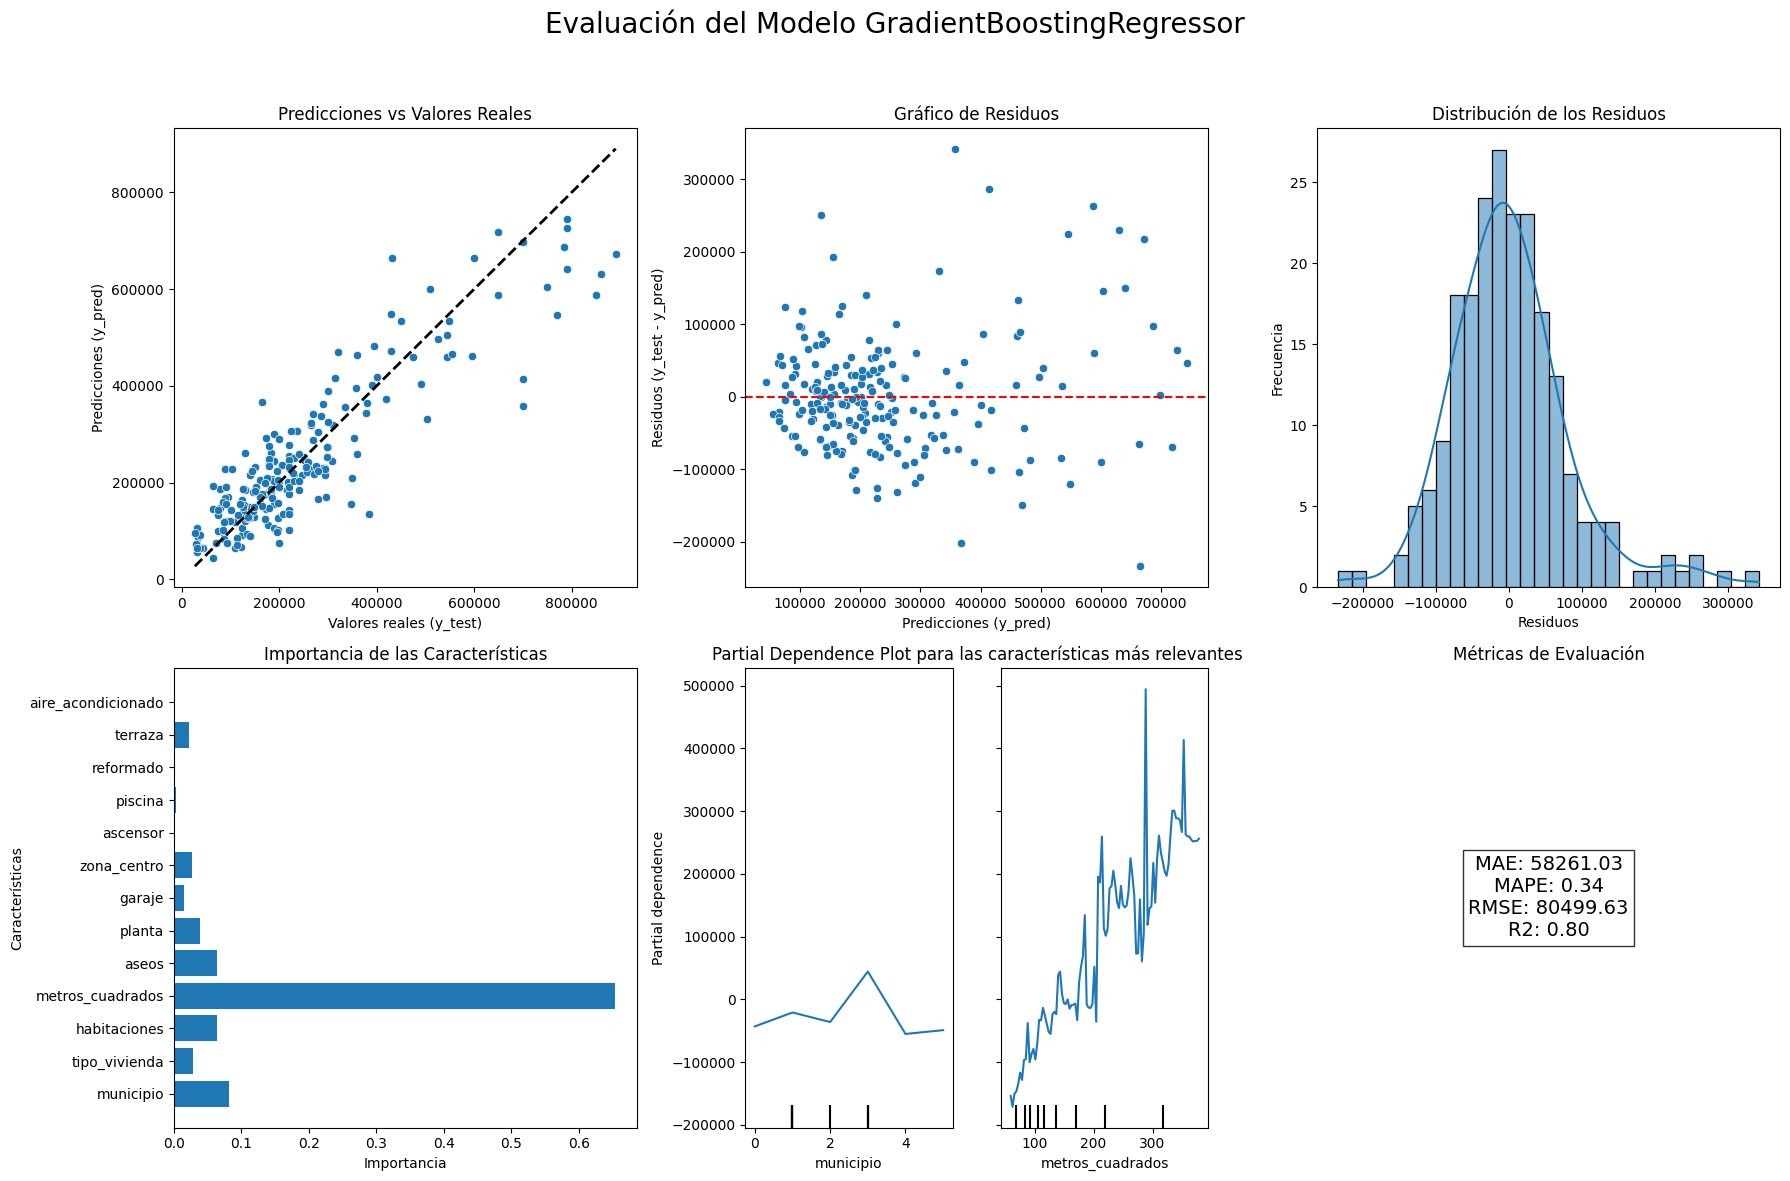

In [100]:
# Calcular residuos
residuos = y_test - y_pred

# Crear la figura y los subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2 filas, 3 columnas
fig.suptitle("Evaluación del Modelo GradientBoostingRegressor", fontsize=20)

# Gráfico 1: Predicciones vs Valores Reales
sns.scatterplot(x=y_test, y=y_pred, ax=axes[0, 0])
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[0, 0].set_title("Predicciones vs Valores Reales")
axes[0, 0].set_xlabel("Valores reales (y_test)")
axes[0, 0].set_ylabel("Predicciones (y_pred)")

# Gráfico 2: Error de Residuos
sns.scatterplot(x=y_pred, y=residuos, ax=axes[0, 1])
axes[0, 1].axhline(0, color='red', linestyle='--')
axes[0, 1].set_title("Gráfico de Residuos")
axes[0, 1].set_xlabel("Predicciones (y_pred)")
axes[0, 1].set_ylabel("Residuos (y_test - y_pred)")

# Gráfico 3: Distribución de Residuos
sns.histplot(residuos, kde=True, bins=30, ax=axes[0, 2])
axes[0, 2].set_title("Distribución de los Residuos")
axes[0, 2].set_xlabel("Residuos")
axes[0, 2].set_ylabel("Frecuencia")

# Gráfico 4: Importancia de las Características
importances = best_gbr.feature_importances_
features = X.columns
axes[1, 0].barh(features, importances)
axes[1, 0].set_title("Importancia de las Características")
axes[1, 0].set_xlabel("Importancia")
axes[1, 0].set_ylabel("Características")

# Obtener las dos características más relevantes
importances = best_gbr.feature_importances_
top_features = [X.columns[i] for i in np.argsort(importances)[-2:]]  # Las 2 más relevantes

# Gráfico 5: Partial Dependence Plot
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(best_gbr, X_train, top_features, ax=axes[1, 1])
axes[1, 1].set_title("Partial Dependence Plot para las características más relevantes")

# Gráfico 6: Métricas de Evaluación
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
metrics_text = f"MAE: {mae:.2f}\nMAPE: {mape:.2f}\nRMSE: {rmse:.2f}\nR2: {r2:.2f}"
axes[1, 2].text(0.5, 0.5, metrics_text, fontsize=14, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))
axes[1, 2].set_title("Métricas de Evaluación")
axes[1, 2].axis('off')

# Ajustar espaciado
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar para no cortar el título general
plt.show()


### De momento, **nuestra mejor version del GradientBoostingRegressor**, es con **TODAS las COLUMNAS**: 

- ### GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=2, n_estimators=400, random_state=42, subsample=0.8) 

- ### MAE: 58571.28240345901
- ### MAPE: 0.3384159599379157
- ### RMSE: 81225.33205804374
- ### R2: 0.7973258019255307

### Despues de esto, se realizan más pruebas en ***Voting_regressor.ipynb*** con nuevos los modelos ***LGBMRegressor*** y ***XGBRegressor***.